<h1> Feature Engineering </h1>

In this notebook, you will learn how to incorporate feature engineering into your pipeline.
<ul>
<li> Working with feature columns </li>
<li> Adding feature crosses in TensorFlow </li>
<li> Reading data from BigQuery </li>
<li> Creating datasets using Dataflow </li>
<li> Using a wide-and-deep model </li>
</ul>

Table of Contents:
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import google.cloud.ml as ml
import tensorflow as tf
import apache_beam as beam
import shutil
print tf.__version__
print ml.sdk_location

No handlers could be found for logger "oauth2client.contrib.multistore_file"


1.0.0
gs://cloud-ml/sdk/cloudml-0.1.9.1-alpha.dataflow.tar.gz


<h2> 1. Environment variables for project and bucket </h2>

Change the cell below to reflect your Project ID and bucket name. See Lab 3a for setup instructions.

In [3]:
import os
PROJECT = 'cloud-training-demos'    # CHANGE THIS
BUCKET = 'cloud-training-demos-ml'  # CHANGE THIS
REGION = 'us-central1' # CHANGE THIS

In [4]:
# for bash
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

<h2> 2. Specifying query to pull the data </h2>

Let's pull out a few extra columns from the timestamp.

In [5]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 < 2".format(base_query)
    else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % 4 == {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(HASH(pickup_datetime)) % {1} == {2}".format(base_query, EVERY_N, phase)
    
  return query
    
print create_query(2, 100000)


SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  DAYOFWEEK(pickup_datetime) AS dayofweek,
  HOUR(pickup_datetime) AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers,
  CONCAT(STRING(pickup_datetime), STRING(pickup_longitude), STRING(pickup_latitude), STRING(dropoff_latitude), STRING(dropoff_longitude)) AS key
FROM
  [nyc-tlc:yellow.trips]
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
   AND ABS(HASH(pickup_datetime)) % 100000 == 2


Try the query above in https://bigquery.cloud.google.com/table/nyc-tlc:yellow.trips if you want to see what it does (ADD LIMIT 10 to the query!)

<h2> 3. Preprocessing Dataflow job from BigQuery </h2>

This code reads from BigQuery and saves the data as-is on Google Cloud Storage.  We can do additional preprocessing and cleanup inside Dataflow, but then we'll have to remember to repeat that prepreprocessing during inference. It is better to use tf.transform which will do this book-keeping for you, or to do preprocessing within your TensorFlow model. We will look at this in future notebooks. For now, we are simply moving data from BigQuery to CSV using Dataflow.

While we could read from BQ directly from TensorFlow (See: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/cloud/bigquery_reader_ops.py), it is quite convenient to export to CSV and do the training off CSV.  Let's use Dataflow to do this at scale.

Because we are running this on the Cloud, you should go to the GCP Console (https://console.cloud.google.com/dataflow) to look at the status of the job. It will take several minutes for the preprocessing job to launch.

In [ ]:
%bash
gsutil -m rm -rf gs://$BUCKET/taxifare/ch4/taxi_preproc/

In [6]:
import datetime

def to_csv(rowdict):
  import copy
  days = ['null', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
  CSV_COLUMNS = 'fare_amount,dayofweek,hourofday,pickuplon,pickuplat,dropofflon,dropofflat,passengers,key'.split(',')
  result = copy.deepcopy(rowdict)
  result['dayofweek'] = days[result['dayofweek']]
  return ','.join([str(result[k]) for k in CSV_COLUMNS])

def preprocess(EVERY_N, RUNNER):
  job_name = 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  print 'Launching Dataflow job {} ... hang on'.format(job_name)
  OUTPUT_DIR = 'gs://{0}/taxifare/ch4/taxi_preproc/'.format(BUCKET)
  options = {
    'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
    'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
    'job_name': 'preprocess-taxifeatures' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S'),
    'project': PROJECT,
    'teardown_policy': 'TEARDOWN_ALWAYS',
    'no_save_main_session': True
  }
  opts = beam.pipeline.PipelineOptions(flags=[], **options)
  p = beam.Pipeline(RUNNER, options=opts)
  for n, step in enumerate(['train', 'valid']):
    query = create_query(n+1, EVERY_N)
    outfile = os.path.join(OUTPUT_DIR, '{}.csv'.format(step))
    (
      p | 'read_{}'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=query))
        | 'tocsv_{}'.format(step) >> beam.Map(to_csv)
        | 'write_{}'.format(step) >> beam.io.Write(beam.io.WriteToText(outfile))
    )

  p.run()

In [ ]:
# Change as needed
#preprocess(50*100000, 'DirectRunner')  # runs locally
preprocess(50*1000, 'DataflowRunner') # runs on cloud; change first arg to None to preprocess full dataset

In [ ]:
%bash
gsutil ls -l gs://$BUCKET/taxifare/ch4/taxi_preproc/

In [ ]:
%bash
gsutil cat "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" | head

<h2> 4. Develop model with new inputs </h2>

Download a fraction of the preprocessed data to enable local development.

In [ ]:
%bash
mkdir sample
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/train.csv-00000-of-*" sample/train.csv
gsutil cp "gs://$BUCKET/taxifare/ch4/taxi_preproc/valid.csv-00000-of-*" sample/valid.csv

We have two new inputs in the INPUT_COLUMNS, three engineered features, and the estimator involves bucketization and feature crosses.

In [ ]:
!grep -A 20 "INPUT_COLUMNS =" taxifare/trainer/model.py

In [ ]:
!grep -A 50 "build_estimator" taxifare/trainer/model.py

In [ ]:
!grep -A 15 "add_engineered(" taxifare/trainer/model.py

Try out the new model on the local sample to make sure it works fine.

In [ ]:
%bash
rm -rf taxifare.tar.gz taxi_trained
export PYTHONPATH=${PYTHONPATH}:/content/training-data-analyst/courses/machine_learning/feateng/taxifare
python -m trainer.task \
   --train_data_paths="/content/training-data-analyst/courses/machine_learning/feateng/sample/train*" \
   --eval_data_paths=/content/training-data-analyst/courses/machine_learning/feateng/sample/valid.csv  \
   --output_dir=/content/training-data-analyst/courses/machine_learning/feateng/taxi_trained \
   --num_epochs=100 --job-dir=/tmp

In [ ]:
!ls /content/training-data-analyst/courses/machine_learning/feateng/taxi_trained/export/Servo

In [ ]:
%writefile /tmp/test.json
{"dayofweek":"Sun","hourofday":17,"pickuplon": -73.885262,"pickuplat": 40.773008,"dropofflon": -73.987232,"dropofflat": 40.732403,"passengers": 2}

In [ ]:
%bash
model_dir=$(ls /content/training-data-analyst/courses/machine_learning/feateng/taxi_trained/export/Servo)
gcloud beta ml local predict \
    --model-dir=/content/training-data-analyst/courses/machine_learning/feateng/taxi_trained/export/Servo/${model_dir} \
    --json-instances=/tmp/test.json

<h2> 5. Train on cloud </h2>


In [ ]:
# might need this ...
# !gcloud --quiet components update

In [ ]:
%%bash
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud beta ml jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=/content/training-data-analyst/courses/machine_learning/feateng/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --runtime-version=1.0 \
   -- \
   --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
   --output_dir=$OUTDIR \http://localhost:8081/notebooks/training-data-analyst/courses/machine_learning/feateng/feateng.ipynb#
   --num_epochs=100 

The RMSE is now 8.33249, an improvement over the 9.3 that we were getting ... of course, we won't know until we train/validate on a larger dataset. Still, this is promising. But before we do that, let's do hyper-parameter tuning.

<h2> 6. Hyper-parameter tune </h2>

Look at <a href="hyperparam.ipynb">hyper-parameter tuning notebook</a> to decide what parameters to use for model. Based on that run, I ended up choosing:
<ol>
<li> train_batch_size: 512 </li>
<li> nbuckets: 16 </li>
<li> hidden_units: "64 64 64 8" </li>    
</ol>

This gives an RMSE of 5, a considerable improvement from the 8.3 we were getting earlier ... Let's try this over full dataset.

<h1> Run Cloud training on 1-million row dataset </h1>

This took 3 hours (15 min for preprocessing, rest for training) and uses as input 1-million rows.  The model is exactly the same as above. The only changes are to the input (to use the larger dataset) and to the Cloud MLE tier (to use STANDARD_1 instead of BASIC -- STANDARD_1 is approximately 10x more powerful than BASIC).

In [ ]:
# this will take approximately 15 minutes!
preprocess(500, 'DataflowRunner')  # overall dataset is 1-billion rows; so 1/500 of that would be 2 million. 50% training

Launch this only after preprocessing is done (look at https://console.cloud.google.com/dataflow)

In [ ]:
%%bash
# this will take 3 hours -- remove this line if you are sure. XXXXX
OUTDIR=gs://${BUCKET}/taxifare/ch4/taxi_trained
JOBNAME=lab4a_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud beta ml jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=/content/training-data-analyst/courses/machine_learning/feateng/taxifare/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=STANDARD_1 \
   --runtime-version=1.0 \
   -- \
   --train_data_paths="gs://$BUCKET/taxifare/ch4/taxi_preproc/train*" \
   --eval_data_paths="gs://${BUCKET}/taxifare/ch4/taxi_preproc/valid*"  \
   --output_dir=$OUTDIR \
   --num_epochs=100 \
   --train_batch_size=512 --nbuckets=16 --hidden_units="64 64 64 8"

The RMSE after training on the full data is \$3.03.  This graph shows the improvements ...

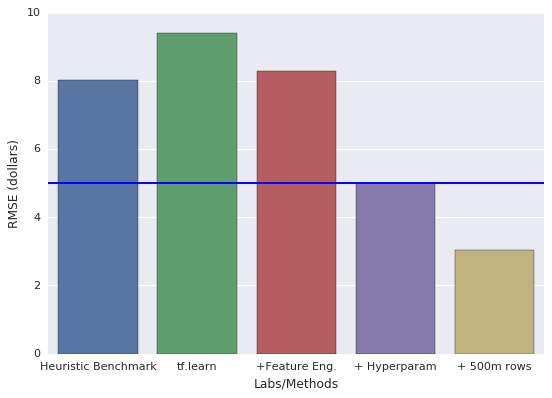

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({'Lab' : pd.Series(['1a', '2-3', '4a', '4b', '4c']),
              'Method' : pd.Series(['Heuristic Benchmark', 'tf.learn', '+Feature Eng.', '+ Hyperparam', '+ 500m rows']),
              'RMSE': pd.Series([8.026, 9.4, 8.3, 5.0, 3.03]) })

ax = sns.barplot(data=df, x='Method', y='RMSE')
ax.set_ylabel('RMSE (dollars)')
ax.set_xlabel('Labs/Methods')
plt.plot(np.linspace(-20,120,1000), [5]*1000, 'b');

Copyright 2016 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License